<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/kimhc6028_curiousity_next.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### setup

In [31]:
# # https://github.com/kimhc6028/pytorch-noreward-rl
# https://stackoverflow.com/questions/67808779/running-gym-atari-in-google-colab
%pip install -U gym
%pip install -U gym[atari,accept-rom-license]

# !pip install gym[box2d]
# import gym


# # https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/54f5097c720c6f2656219ab14a4e7431/mario_rl_tutorial.ipynb
# import gym
# from gym.spaces import Box
# from gym.wrappers import FrameStack
# from nes_py.wrappers import JoypadSpace
# import gym_super_mario_bros

# env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
# env = JoypadSpace(env, [["right"], ["right", "A"]])

!pip install gym-super-mario-bros nes-py
# https://github.com/Kautenja/gym-super-mario-bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# env = gym_super_mario_bros.make('SuperMarioBros-v0')
# env = JoypadSpace(env, SIMPLE_MOVEMENT)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### model

In [39]:
# model.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/model.py
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def normalized_columns_initializer(weights, std=1.0):
    out = torch.randn(weights.size())
    # out *= std / torch.sqrt(out.pow(2).sum(1).expand_as(out))
    out *= std / torch.sqrt(out.pow(2).sum(1).unsqueeze(dim=1).expand_as(out))
    return out

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)


class ActorCritic(torch.nn.Module):
    def __init__(self, num_inputs, action_space):
        super(ActorCritic, self).__init__()
        self.in_dim = num_inputs # mario (240, 256)
        self.conv1 = nn.Conv2d(num_inputs[0], 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.lstm = nn.LSTMCell(num_inputs[1], 256)
        # self.lstm = nn.LSTMCell(32 * 10, 256)
        num_outputs = action_space.n
        self.critic_linear = nn.Linear(256, 1)
        self.actor_linear = nn.Linear(256, num_outputs)
        ################################################################
        self.icm_conv1 = nn.Conv2d(num_inputs[0], 32, 3, stride=2, padding=1)
        self.icm_conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.icm_conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.icm_conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        #self.icm_lstm = nn.LSTMCell(32 * 3 * 3, 256)
        self.inverse_linear1 = nn.Linear(num_inputs[1] + num_inputs[1], 256)
        # self.inverse_linear1 = nn.Linear(320 + 320, 256)
        self.inverse_linear2 = nn.Linear(256, num_outputs)
        self.forward_linear1 = nn.Linear(num_inputs[1] + num_outputs, 256)
        # self.forward_linear1 = nn.Linear(320 + num_outputs, 256)
        self.forward_linear2 = nn.Linear(256, num_inputs[1])
        # self.forward_linear2 = nn.Linear(256, 320)
        #self.inverse_linear1 = nn.Linear(256 + 256, 256)
        #self.inverse_linear2 = nn.Linear(256, num_outputs)

        #self.forward_linear1 = nn.Linear(256 + num_outputs, 256)
        #self.forward_linear2 = nn.Linear(256, 256)
        ################################################################
        self.apply(weights_init)
        self.inverse_linear1.weight.data = normalized_columns_initializer(self.inverse_linear1.weight.data, 0.01)
        self.inverse_linear1.bias.data.fill_(0)
        self.inverse_linear2.weight.data = normalized_columns_initializer(self.inverse_linear2.weight.data, 1.0)
        self.inverse_linear2.bias.data.fill_(0)
        
        self.forward_linear1.weight.data = normalized_columns_initializer(self.forward_linear1.weight.data, 0.01)
        self.forward_linear1.bias.data.fill_(0)
        self.forward_linear2.weight.data = normalized_columns_initializer(self.forward_linear2.weight.data, 1.0)
        self.forward_linear2.bias.data.fill_(0)
        '''
        self.icm_lstm.bias_ih.data.fill_(0)
        self.icm_lstm.bias_hh.data.fill_(0)
        '''
        ################################################################
        self.actor_linear.weight.data = normalized_columns_initializer(self.actor_linear.weight.data, 0.01)
        self.actor_linear.bias.data.fill_(0)
        self.critic_linear.weight.data = normalized_columns_initializer(self.critic_linear.weight.data, 1.0)
        self.critic_linear.bias.data.fill_(0)
        self.lstm.bias_ih.data.fill_(0)
        self.lstm.bias_hh.data.fill_(0)
        self.train()


    def forward(self, inputs, icm):
        if icm == False: #A3C
            inputs, (a3c_hx, a3c_cx) = inputs # [1, 210, 160, 3], ([1, 256], [1, 256])
            x = F.elu(self.conv1(inputs)) # [1, 32, 80, 2]
            x = F.elu(self.conv2(x)) # [1, 32, 40, 1]
            x = F.elu(self.conv3(x)) # [1, 32, 20, 1]
            x = F.elu(self.conv4(x)) # [1, 32, 10, 1] mario[1, 32, 16, 1]
            print("x4",x.shape) # mario[2, 256]
            x = x.view(-1, self.in_dim[1])
            
            print("xv",x.shape)
            # x = x.view(-1, 32 * 10)
            print("wrthf",x.shape, a3c_hx.shape, a3c_cx.shape) # [2, 256], [1, 256], [1, 256]

            a3c_hx, a3c_cx = self.lstm(x, (a3c_hx, a3c_cx))
            x = a3c_hx
            critic = self.critic_linear(x)
            actor = self.actor_linear(x)
            # print("forward A3C ",critic.shape, actor.shape, a3c_hx.shape, a3c_cx.shape)
            return critic, actor, (a3c_hx, a3c_cx) # [1, 1], [1, 18], ([1, 256], [1, 256])

        else: #icm
            s_t, s_t1, a_t = inputs
            # s_t1=s_t1.float()
            # print("###s t###",s_t.dtype) # [1, 210, 160, 3] torch.float32

            '''
            s_t, (icm_hx, icm_cx) = s_t
            s_t1, (icm_hx1, icm_cx1) = s_t1
            '''
            vec_st = F.elu(self.icm_conv1(s_t))
            vec_st = F.elu(self.icm_conv2(vec_st))
            vec_st = F.elu(self.icm_conv3(vec_st))
            vec_st = F.elu(self.icm_conv4(vec_st))
            
            vec_st1 = F.elu(self.icm_conv1(s_t1))
            vec_st1 = F.elu(self.icm_conv2(vec_st1))
            vec_st1 = F.elu(self.icm_conv3(vec_st1))
            vec_st1 = F.elu(self.icm_conv4(vec_st1))
            vec_st = vec_st.view(-1, self.in_dim[1])
            vec_st1 = vec_st1.view(-1, self.in_dim[1])
            # vec_st = vec_st.view(-1, 32 * 10) # [1, 320] torch.float32
            # vec_st1 = vec_st1.view(-1, 32 * 10) # [1, 320] torch.float32

            #icm_hx, icm_cx = self.icm_lstm(vec_st, (icm_hx, icm_cx))
            #icm_hx1, icm_cx1 = self.icm_lstm(vec_st1, (icm_hx1, icm_cx1))
            #vec_st = icm_hx
            #vec_st1 = icm_hx1
            inverse_vec = torch.cat((vec_st, vec_st1), 1)
            forward_vec = torch.cat((vec_st, a_t), 1)
            inverse = self.inverse_linear1(inverse_vec)
            inverse = F.relu(inverse)
            inverse = self.inverse_linear2(inverse)
            inverse = F.softmax(inverse)
            forward = self.forward_linear1(forward_vec)
            forward = F.relu(forward)
            forward = self.forward_linear2(forward)
            # print("forward icm ",vec_st1.shape, inverse.shape, forward.shape)
            return vec_st1, inverse, forward # [1, 320], [1, 18], [1, 320]
            #return vec_st1, inverse, forward, (icm_hx, icm_cx), (icm_hx1, icm_cx1)


#### model simple

In [63]:
# model.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/model.py
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def normalized_columns_initializer(weights, std=1.0):
    out = torch.randn(weights.size())
    out *= std / torch.sqrt(out.pow(2).sum(1).unsqueeze(dim=1).expand_as(out))
    return out

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)


class ActorCritic(torch.nn.Module):
    def __init__(self, num_inputs, action_space):
        super(ActorCritic, self).__init__()
        # self.lstm = nn.LSTMCell(32 * 3 * 3, 256)
        ################################################################
        #self.icm_lstm = nn.LSTMCell(32 * 3 * 3, 256)
        #self.inverse_linear1 = nn.Linear(256 + 256, 256)
        #self.inverse_linear2 = nn.Linear(256, num_outputs)

        #self.forward_linear1 = nn.Linear(256 + num_outputs, 256)
        #self.forward_linear2 = nn.Linear(256, 256)
        ################################################################
        self.apply(weights_init)
        self.inverse_linear1.weight.data = normalized_columns_initializer(self.inverse_linear1.weight.data, 0.01)
        self.inverse_linear1.bias.data.fill_(0)
        self.inverse_linear2.weight.data = normalized_columns_initializer(self.inverse_linear2.weight.data, 1.0)
        self.inverse_linear2.bias.data.fill_(0)
        
        self.forward_linear1.weight.data = normalized_columns_initializer(self.forward_linear1.weight.data, 0.01)
        self.forward_linear1.bias.data.fill_(0)
        self.forward_linear2.weight.data = normalized_columns_initializer(self.forward_linear2.weight.data, 1.0)
        self.forward_linear2.bias.data.fill_(0)
        '''
        self.icm_lstm.bias_ih.data.fill_(0)
        self.icm_lstm.bias_hh.data.fill_(0)
        '''
        ################################################################
        self.actor_linear.weight.data = normalized_columns_initializer(self.actor_linear.weight.data, 0.01)
        self.actor_linear.bias.data.fill_(0)
        self.critic_linear.weight.data = normalized_columns_initializer(self.critic_linear.weight.data, 1.0)
        self.critic_linear.bias.data.fill_(0)
        self.lstm.bias_ih.data.fill_(0)
        self.lstm.bias_hh.data.fill_(0)
        self.train()


class ActorCritic(torch.nn.Module):
    def __init__(self, num_inputs, action_space):
        super(ActorCritic, self).__init__()
        self.in_dim = num_inputs # mario (240, 256)
        self.conv = nn.Sequential(
            nn.Conv2d(num_inputs[0], 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(), # added for RuntimeError: Input batch size 2 doesn't match hidden0 batch size 1
            )
        self.icm_conv = nn.Sequential(
            nn.Conv2d(num_inputs[0], 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(), # added for cat
            )
        self.lstm = nn.LSTMCell(num_inputs[1], 256)
        num_outputs = action_space.n
        self.critic_linear = nn.Linear(256, 1)
        self.actor_linear = nn.Linear(256, num_outputs)

        self.inverse_linear1 = nn.Linear(num_inputs[1] + num_inputs[1], 256)
        self.inverse_linear2 = nn.Linear(256, num_outputs)

        self.forward_linear1 = nn.Linear(num_inputs[1] + num_outputs, 256)
        self.forward_linear2 = nn.Linear(256, num_inputs[1])

    def forward(self, inputs, icm):
        if icm == False: #A3C
            inputs, (a3c_hx, a3c_cx) = inputs # [1, 210, 160, 3], ([1, 256], [1, 256])
            x = self.conv(inputs).view(-1, self.in_dim[1])
            a3c_hx, a3c_cx = self.lstm(x, (a3c_hx, a3c_cx))
            x = a3c_hx
            critic = self.critic_linear(x)
            actor = self.actor_linear(x)
            # print("forward A3C ",critic.shape, actor.shape, a3c_hx.shape, a3c_cx.shape)
            return critic, actor, (a3c_hx, a3c_cx) # [1, 1], [1, 18], ([1, 256], [1, 256])

        else: #icm
            s_t, s_t1, a_t = inputs
            '''
            s_t, (icm_hx, icm_cx) = s_t
            s_t1, (icm_hx1, icm_cx1) = s_t1
            '''
            vec_st = self.icm_conv(s_t).view(-1, self.in_dim[1])
            vec_st1 = self.icm_conv(s_t1).view(-1, self.in_dim[1])
            #icm_hx, icm_cx = self.icm_lstm(vec_st, (icm_hx, icm_cx))
            #icm_hx1, icm_cx1 = self.icm_lstm(vec_st1, (icm_hx1, icm_cx1))
            #vec_st = icm_hx
            #vec_st1 = icm_hx1
            inverse_vec = torch.cat((vec_st, vec_st1), 1)
            forward_vec = torch.cat((vec_st, a_t), 1)

            inverse = self.inverse_linear1(inverse_vec)
            inverse = F.relu(inverse)
            inverse = self.inverse_linear2(inverse)
            inverse = F.softmax(inverse)

            forward = self.forward_linear1(forward_vec)
            forward = F.relu(forward)
            forward = self.forward_linear2(forward)
            # print("forward icm ",vec_st1.shape, inverse.shape, forward.shape)
            return vec_st1, inverse, forward # [1, 320], [1, 18], [1, 320]
            #return vec_st1, inverse, forward, (icm_hx, icm_cx), (icm_hx1, icm_cx1)


#### model simplier

In [76]:
# model.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/model.py
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ActorCritic(torch.nn.Module):
    def __init__(self, in_shape, action_space):
        super(ActorCritic, self).__init__()
        self.in_dim = in_shape # mario (240, 256)
        self.conv = nn.Sequential(
            nn.Conv2d(in_shape[0], 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(), # added for RuntimeError: Input batch size 2 doesn't match hidden0 batch size 1
            )
        self.icm_conv = nn.Sequential(
            nn.Conv2d(in_shape[0], 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(), # added for cat
            )
        # self.lstm = nn.LSTMCell(in_shape[1], 256)
        self.lstm = nn.LSTM(in_shape[1], 256)
        num_outputs = action_space.n
        self.critic_linear = nn.Linear(256, 1)
        self.actor_linear = nn.Linear(256, num_outputs)

        self.inv_linear = nn.Sequential(
            nn.Linear(in_shape[1] + in_shape[1], 256), nn.ReLU(),
            nn.Linear(256, num_outputs), nn.Softmax()
            )
        self.fwd_linear = nn.Sequential(
            nn.Linear(in_shape[1] + num_outputs, 256), nn.ReLU(),
            nn.Linear(256, in_shape[1])
            )

    def forward(self, inputs, icm):
        if icm == False: #A3C
            inputs, (a3c_hx, a3c_cx) = inputs # [1, 210, 160, 3], ([1, 256], [1, 256])
            x = self.conv(inputs).view(-1, self.in_dim[1])
            a3c_hx, a3c_cx = self.lstm(x, (a3c_hx, a3c_cx))
            x = a3c_hx
            critic = self.critic_linear(x)
            actor = self.actor_linear(x)
            # print("forward A3C ",critic.shape, actor.shape, a3c_hx.shape, a3c_cx.shape)
            return critic, actor, (a3c_hx, a3c_cx) # [1, 1], [1, 18], ([1, 256], [1, 256])

        else: #icm
            s_t, s_t1, a_t = inputs
            '''
            s_t, (icm_hx, icm_cx) = s_t
            s_t1, (icm_hx1, icm_cx1) = s_t1
            '''
            vec_st = self.icm_conv(s_t).view(-1, self.in_dim[1])
            vec_st1 = self.icm_conv(s_t1).view(-1, self.in_dim[1])
            #icm_hx, icm_cx = self.icm_lstm(vec_st, (icm_hx, icm_cx))
            #icm_hx1, icm_cx1 = self.icm_lstm(vec_st1, (icm_hx1, icm_cx1))
            #vec_st = icm_hx
            #vec_st1 = icm_hx1
            inverse_vec = torch.cat((vec_st, vec_st1), 1)
            forward_vec = torch.cat((vec_st, a_t), 1)
            inverse = self.inv_linear(inverse_vec)
            forward = self.fwd_linear(forward_vec)
            # print("forward icm ",vec_st1.shape, inverse.shape, forward.shape)
            return vec_st1, inverse, forward # [1, 320], [1, 18], [1, 320]
            #return vec_st1, inverse, forward, (icm_hx, icm_cx), (icm_hx1, icm_cx1)


#### perceiverio

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!pip install perceiver-pytorch

In [ ]:
from perceiver_pytorch import PerceiverIO
# https://github.com/lucidrains/perceiver-pytorch
actor = PerceiverIO(
    dim = env.observation_space.shape[0]*env.observation_space.shape[1],                    # dimension of sequence to be encoded
    queries_dim = env.action_space,            # dimension of decoder queries
    logits_dim = None,            # dimension of final logits
    depth = 6,                   # depth of net
    num_latents = 64,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 64,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 16,         # number of dimensions per cross attention head
    latent_dim_head = 16,        # number of dimensions per latent self attention head
    weight_tie_layers = False    # whether to weight tie layers (optional, as indicated in the diagram)
).to(device)

critic = PerceiverIO(
    dim = env.observation_space.shape[0]*env.observation_space.shape[1],                    # dimension of sequence to be encoded
    queries_dim = env.action_space,            # dimension of decoder queries
    logits_dim = None,            # dimension of final logits
    depth = 6,                   # depth of net
    num_latents = 64,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 64,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 16,         # number of dimensions per cross attention head
    latent_dim_head = 16,        # number of dimensions per latent self attention head
    weight_tie_layers = False    # whether to weight tie layers (optional, as indicated in the diagram)
).to(device)

lstm = PerceiverIO(
    dim = 256,                    # dimension of sequence to be encoded
    queries_dim = 256,            # dimension of decoder queries
    logits_dim = None,            # dimension of final logits
    depth = 6,                   # depth of net
    num_latents = 64,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 64,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 16,         # number of dimensions per cross attention head
    latent_dim_head = 16,        # number of dimensions per latent self attention head
    weight_tie_layers = False    # whether to weight tie layers (optional, as indicated in the diagram)
).to(device)



    def forward(self, inputs, icm):
        if icm == False: #A3C
            inputs, (a3c_hx, a3c_cx) = inputs # [1, 210, 160, 3], ([1, 256], [1, 256])


            x = F.elu(self.conv4(x)) # [1, 32, 10, 1]
            # x = x.view(-1, 32 * 3 * 3)
            x = x.view(-1, 32 * 10)

            a3c_hx, a3c_cx = self.lstm(x, (a3c_hx, a3c_cx))

            return critic, actor, (a3c_hx, a3c_cx) # [1, 1], [1, 18], ([1, 256], [1, 256])

        else: #icm
            s_t, s_t1, a_t = inputs
            # s_t1=s_t1.float()
            # print("###s t###",s_t.dtype) # [1, 210, 160, 3] torch.float32


            return vec_st1, inverse, forward # [1, 320], [1, 18], [1, 320]



NameError: ignored

#### train

In [56]:
# train.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/train.py
import math, os, sys, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import time

def ensure_shared_grads(model, shared_model):
    for param, shared_param in zip(model.parameters(), shared_model.parameters()):
        if shared_param.grad is not None:
            return
        shared_param._grad = param.grad

def train(rank, args, shared_model, optimizer=None):
    mse_loss = torch.nn.MSELoss()
    nll_loss = torch.nn.NLLLoss()
    torch.manual_seed(seed + rank)
    # env = gym.make(env_name)
    env = gym_super_mario_bros.make('SuperMarioBros-v0')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    
    num_outputs = env.action_space.n
    print("env.observation_space.shape",env.observation_space.shape)
    model = ActorCritic(env.observation_space.shape, env.action_space)
    if optimizer is None:
        optimizer = optim.Adam(shared_model.parameters(), lr)
    model.train()
    state = env.reset()
    # [1, 210, 160, 3]
    # #xxx### torch.Size([1, 32, 10, 1]
    # state=state[:,:,0]
    state = torch.from_numpy(state.copy()).type(torch.float) # i added, change from int to float

    done = True
    episode_length = 0
    # while True:
    for x in range(num_episodes):
        episode_length += 1
        # Sync with the shared model
        model.load_state_dict(shared_model.state_dict())
        if done:
            cx = Variable(torch.zeros(1, 256))
            hx = Variable(torch.zeros(1, 256))
        else:
            cx = Variable(cx.data)
            hx = Variable(hx.data)
        values = []
        log_probs = []
        rewards = []
        entropies = []
        inverses = []
        forwards = []
        actions = []
        vec_st1s = []

        # print("#####www####",state.dtype,hx.dtype)
        for step in range(num_steps):
            # print("#####www####",Variable(state.unsqueeze(0)).dtype,(state.unsqueeze(0).dtype))
            value, logit, (hx, cx) = model((Variable(state.unsqueeze(0)), (hx, cx)), icm = False)
            s_t = state
            # print("logit.size",logit.shape) # [1, 6]
            prob = F.softmax(logit, dim=1)
            log_prob = F.log_softmax(logit, dim=1)
            entropy = -(log_prob * prob).sum(1)
            entropies.append(entropy)
            # action = prob.multinomial().data
            action = prob.multinomial(1).data
            log_prob = log_prob.gather(1, Variable(action))
            oh_action = torch.Tensor(1, num_outputs)
            oh_action.zero_()
            oh_action.scatter_(1,action,1)
            oh_action = Variable(oh_action)
            a_t = oh_action
            actions.append(oh_action)
            # print("action.numpy()",action.numpy())
            state, reward, done, _ = env.step(action.numpy()[0][0])
            state = torch.from_numpy(state.copy()).type(torch.float)

            # print("###o###",state.dtype)
            # state=state[:,:,0]

            done = done or episode_length >= max_episode_length
            reward = max(min(reward, 1), -1)
            s_t1 = state.float()
            # print("###st###",s_t.unsqueeze(0).dtype)
            # print("###vst###",Variable(s_t.unsqueeze(0)).dtype)
            vec_st1, inverse, forward = model((Variable(s_t.unsqueeze(0)), Variable(s_t1.unsqueeze(0)), a_t), icm = True)            

            reward_intrinsic = eta * ((vec_st1 - forward).pow(2)).sum(1) / 2.
            #reward_intrinsic = eta * ((vec_st1 - forward).pow(2)).sum(1).sqrt() / 2.
            # print("reward_intrinsic", reward_intrinsic.data.numpy())
            # reward_intrinsic = reward_intrinsic.data.numpy()[0][0]
            reward_intrinsic = reward_intrinsic.data.numpy()
            # print("ep ",x,", rwd ext: ", reward.item(), " ,rwd int: ", reward_intrinsic.item())
            print("ep ",x,", rwd ext: ", reward, " ,rwd int: ", reward_intrinsic.item())
            reward += reward_intrinsic

            if done:
                episode_length = 0
                state = env.reset()
                state = torch.from_numpy(state).type(torch.float)


            values.append(value)
            log_probs.append(log_prob)
            rewards.append(reward)
            vec_st1s.append(vec_st1)
            inverses.append(inverse)
            forwards.append(forward)
            if done:
                break
        R = torch.zeros(1, 1)
        if not done:
            value, _, _ = model((Variable(state.unsqueeze(0)), (hx, cx)), icm = False)
            R = value.data
        values.append(Variable(R))
        policy_loss = 0
        value_loss = 0
        inverse_loss = 0
        forward_loss = 0
        R = Variable(R)
        gae = torch.zeros(1, 1)
        for i in reversed(range(len(rewards))):
            R = gamma * R + rewards[i]
            advantage = R - values[i]
            value_loss = value_loss + 0.5 * advantage.pow(2)
            # Generalized Advantage Estimataion
            # print(torch.tensor(rewards[i]) , gamma * values[i + 1].data , values[i].data)
            # delta_t = rewards[i] + gamma * values[i + 1].data - values[i].data
            delta_t = torch.tensor(rewards[i]) + gamma * values[i + 1].data - values[i].data
            gae = gae * gamma * tau + delta_t
            policy_loss = policy_loss - log_probs[i] * Variable(gae) - 0.01 * entropies[i]
            cross_entropy = - (actions[i] * torch.log(inverses[i] + 1e-15)).sum(1)
            inverse_loss = inverse_loss + cross_entropy
            forward_err = forwards[i] - vec_st1s[i]
            forward_loss = forward_loss + 0.5 * (forward_err.pow(2)).sum(1)
        optimizer.zero_grad()
        # ((1-beta) * inverse_loss + beta * forward_loss).backward(retain_variables=True)
        inv_loss = (1-beta) * inverse_loss + beta * forward_loss
        pol_loss = lmbda * (policy_loss + 0.5 * value_loss)
        (inv_loss + pol_loss).backward()
        # (inv_loss + 0*pol_loss).backward()
        # (((1-beta) * inverse_loss + beta * forward_loss) + lmbda * (policy_loss + 0.5 * value_loss)).backward()
        print("ep ",x,", inv_loss: ", inv_loss.item(), " ,pol_loss: ", pol_loss.item())
        torch.nn.utils.clip_grad_norm(model.parameters(), 40)
        ensure_shared_grads(model, shared_model)
        optimizer.step()


#### test

In [70]:
# test.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/test.py
import math, os, sys, random, pickle
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import time
from collections import deque

def test(rank, args, shared_model):
    torch.manual_seed(seed + rank)
    # env = gym.make(env_name)
    env = gym_super_mario_bros.make('SuperMarioBros-v0')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    model = ActorCritic(env.observation_space.shape, env.action_space)
    model.eval()
    state = env.reset()
    state = torch.from_numpy(state.copy()).type(torch.float)

    reward_sum = 0
    done = True
    start_time = time.time()
    # a quick hack to prevent the agent from stucking
    actions = deque(maxlen=2100)
    episode_length = 0
    result = []
    # while True:
    for x in range(5):
        episode_length += 1
        # Sync with the shared model
        if done:
            model.load_state_dict(shared_model.state_dict())
            cx = Variable(torch.zeros(1, 256), volatile=True)
            hx = Variable(torch.zeros(1, 256), volatile=True)
        else:
            cx = Variable(cx.data, volatile=True)
            hx = Variable(hx.data, volatile=True)
        value, logit, (hx, cx) = model((Variable(state.unsqueeze(0), volatile=True), (hx, cx)), icm = False)

        prob = F.softmax(logit)
        action = prob.max(1)[1].data.numpy()
        # print("action",action)
        # state, reward, done, _ = env.step(action[0, 0])
        state, reward, done, _ = env.step(action[0])
        state = torch.from_numpy(state.copy()).type(torch.float)

        done = done or episode_length >= max_episode_length
        print("ep ",x,", rwd ext: ", reward)

        reward_sum += reward
        # a quick hack to prevent the agent from stucking
        # actions.append(action[0, 0])
        actions.append(action[0])
        if actions.count(actions[0]) == actions.maxlen:
            done = True
        if done:
            end_time = time.time()
            print("Time {}, episode reward {}, episode length {}".format(
                time.strftime("%Hh %Mm %Ss", time.gmtime(end_time - start_time)), reward_sum, episode_length))
            result.append((reward_sum, end_time - start_time))
            # f = open('output/result.pickle','w')
            # pickle.dump(result, f)
            # f.close()
            # torch.save(model.state_dict(), 'output/{}.pth'.format((end_time - start_time)))
            torch.save(model.state_dict(), 'model.pth')
            reward_sum = 0
            episode_length = 0
            actions.clear()
            state = env.reset()
            state = torch.from_numpy(state).type(torch.float)
            # time.sleep(60)


#### my_optim

In [35]:
# my_optim.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/my_optim.py
import math
import torch
import torch.optim as optim

class SharedAdam(optim.Adam):
    """Implements Adam algorithm with shared states."""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        super(SharedAdam, self).__init__(params, lr, betas, eps, weight_decay)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = torch.zeros(1)
                state['exp_avg'] = p.data.new().resize_as_(p.data).zero_()
                state['exp_avg_sq'] = p.data.new().resize_as_(p.data).zero_()

    def share_memory(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'].share_memory_()
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

    def step(self, closure=None):
        """Performs a single optimization step.
        closure (callable, optional): A closure that reevaluates the model and returns the loss."""
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)
                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step'][0]
                bias_correction2 = 1 - beta2 ** state['step'][0]
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                p.data.addcdiv_(-step_size, exp_avg, denom)
        return loss


#### main

In [77]:
# main.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/main.py
import os, sys, cv2
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import gym

lr=0.001
gamma=0.99
tau=1.00
seed=1
num_processes=4
num_steps=20
max_episode_length=10000
# env_name='PongDeterministic-v4'
# env_name='LunarLander-v2'
# env_name='MontezumaRevengeDeterministic-v4'
# env_name='MontezumaRevengeDeterministic-ram-v4'



no_shared=False
eta=0.01
beta=0.2
lmbda=0.1
outdir="output"
record='store_true'
num_episodes=100

torch.manual_seed(seed)
# env = gym.make(env_name)
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# print(env.observation_space.shape, env.action_space) # (210, 160, 3) Discrete(18)

shared_model = ActorCritic(env.observation_space.shape, env.action_space)
shared_model.share_memory()
if no_shared:
    optimizer = None
else:
    optimizer = SharedAdam(shared_model.parameters(), lr=lr)
    optimizer.share_memory()
args=None
train(0, args, shared_model, optimizer)

# processes = []
# import torch.multiprocessing as mp
# p = mp.Process(target=test, args=(num_processes, args, shared_model))
# p.start()
# processes.append(p)
# for rank in range(0, num_processes):
#     p = mp.Process(target=train, args=(rank, args, shared_model, optimizer))
#     p.start()
#     processes.append(p)
# for p in processes:
#     p.join()



/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:565: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


env.observation_space.shape (240, 256, 3)
ep  0 , rwd ext:  0.0  ,rwd int:  0.17477309703826904
ep  0 , rwd ext:  0.0  ,rwd int:  0.17465953528881073
ep  0 , rwd ext:  0.0  ,rwd int:  0.17263667285442352
ep  0 , rwd ext:  0.0  ,rwd int:  0.17361171543598175
ep  0 , rwd ext:  0.0  ,rwd int:  0.17595401406288147
ep  0 , rwd ext:  0.0  ,rwd int:  0.17828349769115448
ep  0 , rwd ext:  1.0  ,rwd int:  0.17662882804870605
ep  0 , rwd ext:  0.0  ,rwd int:  0.17773763835430145
ep  0 , rwd ext:  0.0  ,rwd int:  0.17705102264881134
ep  0 , rwd ext:  1.0  ,rwd int:  0.17699278891086578
ep  0 , rwd ext:  0.0  ,rwd int:  0.17541812360286713
ep  0 , rwd ext:  1.0  ,rwd int:  0.17457711696624756


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


ep  0 , rwd ext:  0.0  ,rwd int:  0.17686860263347626
ep  0 , rwd ext:  1.0  ,rwd int:  0.17531347274780273
ep  0 , rwd ext:  0.0  ,rwd int:  0.17696799337863922
ep  0 , rwd ext:  1.0  ,rwd int:  0.17746210098266602
ep  0 , rwd ext:  1.0  ,rwd int:  0.17742213606834412
ep  0 , rwd ext:  0.0  ,rwd int:  0.1790722757577896
ep  0 , rwd ext:  0.0  ,rwd int:  0.17647726833820343
ep  0 , rwd ext:  1.0  ,rwd int:  0.17498524487018585
ep  0 , inv_loss:  101.38805389404297  ,pol_loss:  47.46295928955078
ep  1 , rwd ext:  0.0  ,rwd int:  0.06386930495500565
ep  1 , rwd ext:  1.0  ,rwd int:  0.06463196873664856
ep  1 , rwd ext:  1.0  ,rwd int:  0.06409358978271484
ep  1 , rwd ext:  1.0  ,rwd int:  0.0637512356042862
ep  1 , rwd ext:  1.0  ,rwd int:  0.06471216678619385
ep  1 , rwd ext:  1.0  ,rwd int:  0.0646563470363617
ep  1 , rwd ext:  1.0  ,rwd int:  0.06438841670751572
ep  1 , rwd ext:  1.0  ,rwd int:  0.06400559097528458
ep  1 , rwd ext:  1.0  ,rwd int:  0.06397056579589844
ep  1 , rwd ext:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


ep  1 , rwd ext:  1.0  ,rwd int:  0.0638539046049118
ep  1 , rwd ext:  1.0  ,rwd int:  0.06366060674190521
ep  1 , rwd ext:  1.0  ,rwd int:  0.06400397419929504
ep  1 , rwd ext:  1  ,rwd int:  0.0641457661986351
ep  1 , rwd ext:  1.0  ,rwd int:  0.06449003517627716
ep  1 , rwd ext:  1.0  ,rwd int:  0.06468452513217926
ep  1 , rwd ext:  1  ,rwd int:  0.06411994993686676
ep  1 , rwd ext:  1.0  ,rwd int:  0.06487186998128891
ep  1 , rwd ext:  1.0  ,rwd int:  0.06475590914487839
ep  1 , rwd ext:  1.0  ,rwd int:  0.0638863742351532
ep  1 , inv_loss:  56.502685546875  ,pol_loss:  108.84648895263672
ep  2 , rwd ext:  1  ,rwd int:  0.0839044377207756
ep  2 , rwd ext:  1  ,rwd int:  0.08412684500217438
ep  2 , rwd ext:  1.0  ,rwd int:  0.08557336032390594
ep  2 , rwd ext:  1  ,rwd int:  0.0841832235455513
ep  2 , rwd ext:  1.0  ,rwd int:  0.0832180306315422
ep  2 , rwd ext:  1  ,rwd int:  0.08433787524700165
ep  2 , rwd ext:  1  ,rwd int:  0.08405427634716034
ep  2 , rwd ext:  1  ,rwd int:  0.0

#### wwwwwwwww

In [78]:
# train(0, args, shared_model, optimizer)
# test(0, args, shared_model)

for x in range(20):
    train(x, args, shared_model, optimizer)
    test(x, args, shared_model)


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:565: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


env.observation_space.shape (240, 256, 3)
ep  0 , rwd ext:  0.0  ,rwd int:  0.0012908834032714367
ep  0 , rwd ext:  0.0  ,rwd int:  0.0014293348649516702
ep  0 , rwd ext:  0.0  ,rwd int:  0.001277240226045251
ep  0 , rwd ext:  0.0  ,rwd int:  0.00128572853282094
ep  0 , rwd ext:  0.0  ,rwd int:  0.0015668784035369754
ep  0 , rwd ext:  0.0  ,rwd int:  0.0015873635420575738
ep  0 , rwd ext:  1.0  ,rwd int:  0.0012892218073830009
ep  0 , rwd ext:  0.0  ,rwd int:  0.0014412498567253351
ep  0 , rwd ext:  0.0  ,rwd int:  0.0013025382068008184
ep  0 , rwd ext:  1.0  ,rwd int:  0.0013136746129021049
ep  0 , rwd ext:  0.0  ,rwd int:  0.0013009649701416492
ep  0 , rwd ext:  1.0  ,rwd int:  0.0012883612653240561
ep  0 , rwd ext:  0.0  ,rwd int:  0.0015729096485301852
ep  0 , rwd ext:  1.0  ,rwd int:  0.0013160931412130594
ep  0 , rwd ext:  0.0  ,rwd int:  0.0013084145030006766
ep  0 , rwd ext:  1.0  ,rwd int:  0.0013136285124346614
ep  0 , rwd ext:  1.0  ,rwd int:  0.0015931677771732211
ep  0 , r

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


ep  1 , rwd ext:  1.0  ,rwd int:  0.001902774558402598
ep  1 , rwd ext:  1.0  ,rwd int:  0.0018988350639119744
ep  1 , rwd ext:  1  ,rwd int:  0.0019187541911378503
ep  1 , rwd ext:  1.0  ,rwd int:  0.001562040764838457
ep  1 , rwd ext:  1.0  ,rwd int:  0.0016174445627257228
ep  1 , rwd ext:  1  ,rwd int:  0.001904591335915029
ep  1 , rwd ext:  1.0  ,rwd int:  0.0017776256427168846
ep  1 , rwd ext:  1  ,rwd int:  0.0016013061394914985
ep  1 , rwd ext:  0.0  ,rwd int:  0.0018992307595908642
ep  1 , rwd ext:  1  ,rwd int:  0.0015658042393624783
ep  1 , inv_loss:  34.6148567199707  ,pol_loss:  89.43639373779297
ep  2 , rwd ext:  1.0  ,rwd int:  0.0023472027387470007
ep  2 , rwd ext:  1  ,rwd int:  0.002015539212152362
ep  2 , rwd ext:  1.0  ,rwd int:  0.002260832116007805
ep  2 , rwd ext:  1  ,rwd int:  0.002453054068610072
ep  2 , rwd ext:  1  ,rwd int:  0.0020276429131627083
ep  2 , rwd ext:  1  ,rwd int:  0.002011945703998208
ep  2 , rwd ext:  1.0  ,rwd int:  0.0020997568499296904
ep  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Streaming output truncated to the last 5000 lines.
ep  62 , rwd ext:  0.0  ,rwd int:  0.017250051721930504
ep  62 , rwd ext:  0.0  ,rwd int:  0.01680978573858738
ep  62 , rwd ext:  0.0  ,rwd int:  0.017079833894968033
ep  62 , rwd ext:  -1.0  ,rwd int:  0.01698875240981579
ep  62 , rwd ext:  0.0  ,rwd int:  0.016887782141566277
ep  62 , inv_loss:  39.58534622192383  ,pol_loss:  -2.336576223373413
ep  63 , rwd ext:  0.0  ,rwd int:  0.016986746340990067
ep  63 , rwd ext:  0.0  ,rwd int:  0.01687558740377426
ep  63 , rwd ext:  0.0  ,rwd int:  0.01679886505007744
ep  63 , rwd ext:  0.0  ,rwd int:  0.016886748373508453
ep  63 , rwd ext:  0.0  ,rwd int:  0.016894347965717316
ep  63 , rwd ext:  0.0  ,rwd int:  0.016960961744189262
ep  63 , rwd ext:  0.0  ,rwd int:  0.017101652920246124
ep  63 , rwd ext:  0.0  ,rwd int:  0.016962898895144463
ep  63 , rwd ext:  0.0  ,rwd int:  0.017164990305900574
ep  63 , rwd ext:  0.0  ,rwd int:  0.017298443242907524
ep  63 , rwd ext:  0.0  ,rwd int:  0.01697

In [79]:

# # (optional:) mount to google drive to save the model
from google.colab import drive
drive.mount('/content/gdrive')
PATH="/content/gdrive/MyDrive/kimhc6028_curiousity_next" # for saving to google drive
# PATH="/content" # for saving on colab only
torch.save(shared_model.state_dict(), 'model_mario_simplier.pth')




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [80]:
# !apt install python-opengl ffmpeg xvfb
# https://github.com/openai/gym/issues/1898#issuecomment-860034155
!apt-get install python-opengl -y xvfb
!pip install pyvirtualdisplay 
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,687 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 1,280 kB in 0s (2,950 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously un

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:565: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:298: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`
  "No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_

(240, 256, 3)


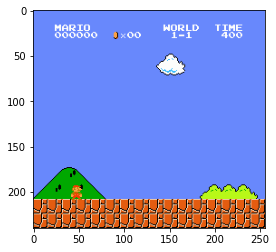

In [82]:

# env = gym.make(env_name)
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

action_space = env.action_space.n
state_space = env.observation_space.shape[0]
state = env.reset()
state = torch.from_numpy(state.copy()).type(torch.float)

# print("state",state,state.shape)
action = env.action_space.sample() # Take a random action
observation, reward, done, info = env.step(action)
# print(observation)
display = Display(visible=0, size=(1400, 900))
display.start()
screen = env.render(mode='rgb_array')

import matplotlib.pyplot as plt
plt.imshow(screen)
# plt.imshow(screen[:,:,0])
plt.grid(False)
print(screen.shape) #(400, 600, 3)


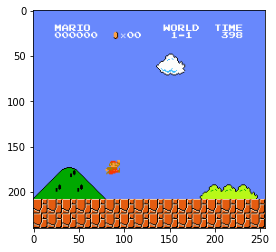

In [83]:
# env = gym.make("LunarLander-v2")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

from IPython import display
# https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab
for i in range(200):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
#   ipythondisplay.clear_output(wait=True)
#   ipythondisplay.display(plt.gcf())
  display.display(plt.gcf())
  display.clear_output(wait=True)
  if done:
    break

# ipythondisplay.clear_output(wait=True)
env.close()

In [ ]:

model=shared_model
# model = ActorCritic(env.observation_space.shape[0], env.action_space)

# model.load_state_dict(shared_model.state_dict())
cx = Variable(torch.zeros(1, 256), volatile=True)
hx = Variable(torch.zeros(1, 256), volatile=True)
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
while True:
# for x in range(5):
    # Sync with the shared model

    cx = Variable(cx.data, volatile=True)
    hx = Variable(hx.data, volatile=True)
    value, logit, (hx, cx) = model((Variable(state.unsqueeze(0), volatile=True), (hx, cx)), icm = False)
    prob = F.softmax(logit)
    action = prob.max(1)[1].data.numpy()
    # print("action",action)
    # state, reward, done, _ = env.step(action[0, 0])
    state, reward, done, _ = env.step(action[0])
    state = torch.from_numpy(state)
    state = torch.tensor(state, dtype=torch.float)

    # action = env.action_space.sample()
    # obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    #   ipythondisplay.clear_output(wait=True)
    #   ipythondisplay.display(plt.gcf())
    display.display(plt.gcf())
    display.clear_output(wait=True)


    # done = done or episode_length >= max_episode_length
    # print("ep ",x,", rwd ext: ", reward)

    # reward_sum += reward
    # a quick hack to prevent the agent from stucking
    # actions.append(action[0, 0])
    # actions.append(action[0])
    # if actions.count(actions[0]) == actions.maxlen:
    #     done = True
    if done:
        end_time = time.time()
        # print("Time {}, episode reward {}, episode length {}".format(
        #     time.strftime("%Hh %Mm %Ss", time.gmtime(end_time - start_time)), reward_sum, episode_length))
        # result.append((reward_sum, end_time - start_time))
        reward_sum = 0
        episode_length = 0
        # actions.clear()
        env.reset()

In [ ]:
env = gym.make("LunarLander-v2")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

from IPython import display
# https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab
for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
#   ipythondisplay.clear_output(wait=True)
#   ipythondisplay.display(plt.gcf())
  display.display(plt.gcf())
  display.clear_output(wait=True)
  if done:
    break

# ipythondisplay.clear_output(wait=True)
env.close()